# Imports

In [10]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from scipy import stats
import graphviz
import astropy.units as u

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from functools import partial

import os
import warnings
#os.environ["MKL_THREADING_LAYER"] = "GNU"
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-dark-palette')

/tmp/ipykernel_28312/1667230561.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [12]:
plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

# Data 

## Tess

In [13]:
#sectors times, 41-48
from astropy.time import Time
sectors = ['2021-07-24T11:45:00','2021-08-20T02:05:00','2022-01-28T10:25:00','2022-02-25T11:50:00']
sectors_times = Time(sectors, format='fits')
sectors_times_btjd = sectors_times.jd-2457000
sectors_times_btjd

array([2419.98958333, 2446.58680556, 2607.93402778, 2635.99305556])

In [14]:
lk.search_lightcurve('TIC 99869022')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector,2019,DIAMANTE,1800,99869022,0.0
1,TESS Sector 14,2019,TESS-SPOC,1800,99869022,0.0
2,TESS Sector 14,2019,QLP,1800,99869022,0.0
3,TESS Sector 14,2019,TASOC,1800,99869022,0.0
4,TESS Sector 14,2019,TASOC,1800,99869022,0.0
5,TESS Sector 21,2020,TESS-SPOC,1800,99869022,0.0
6,TESS Sector 21,2020,QLP,1800,99869022,0.0
7,TESS Sector 41,2021,SPOC,120,99869022,0.0
8,TESS Sector 41,2021,TESS-SPOC,600,99869022,0.0


Text(0, 0.5, 'Relative flux')

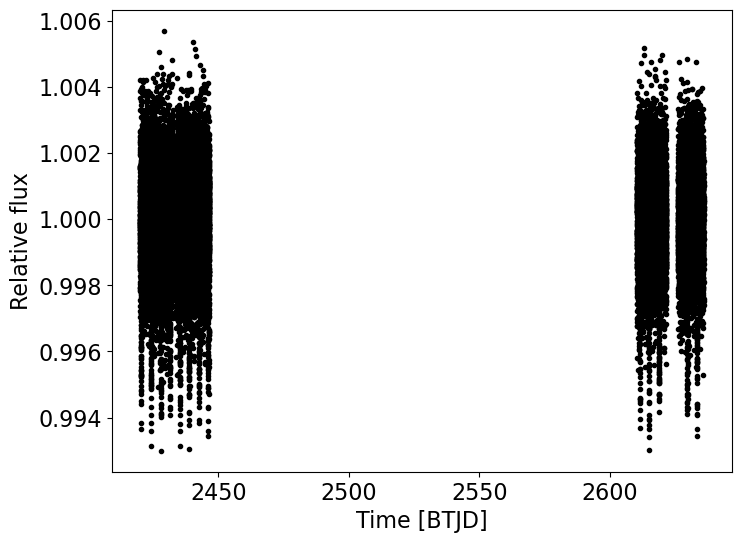

In [15]:
lc_file = lk.search_lightcurve('TIC 99869022', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64) 

plt.plot(time, flux, ".k")
plt.xlabel("Time [BTJD]")
plt.ylabel("Relative flux")
#_ = plt.xlim(x_.min(), x_.max())
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

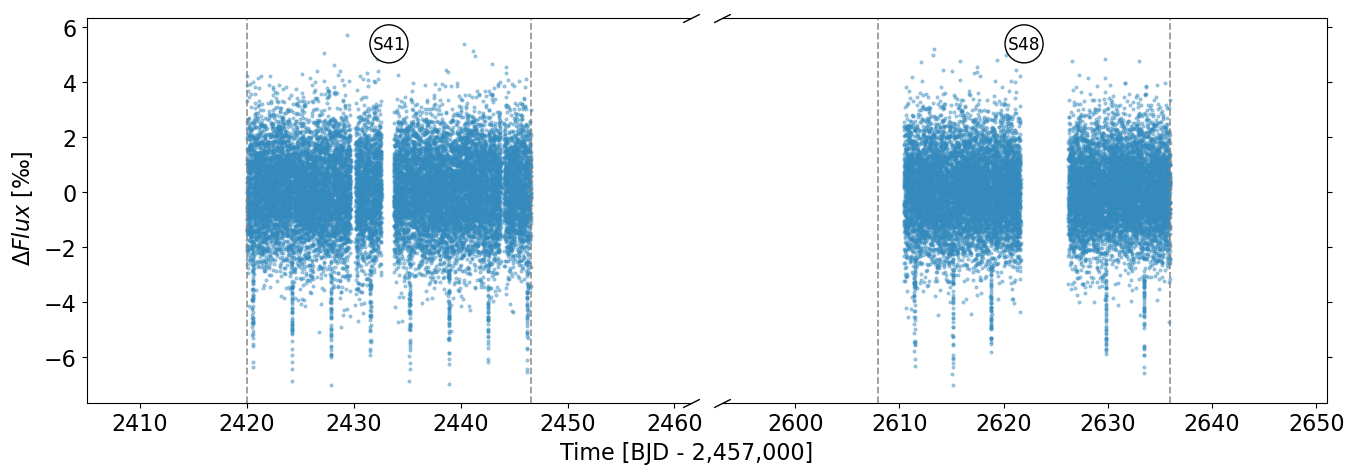

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,5), gridspec_kw={'width_ratios': [1, 1]})
fig.subplots_adjust(wspace=0.05)
ax1.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
ax2.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
off=15
ax1.set_xlim(sectors_times_btjd[0]-off, sectors_times_btjd[1]+off)  
ax2.set_xlim(sectors_times_btjd[2]-off, sectors_times_btjd[3]+off)  
#ax2.set_xticks([2600, 2650, 2700])
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax1.tick_params(labelright=False)
ax2.tick_params(labelleft=False)

d = .5  
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
for i in sectors_times_btjd[:2]:
    ax1.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[2:]:
    ax2.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
fig.text(0.5, 0.01, "Time [BJD - 2,457,000]", ha='center', va='center')
fig.text(0.085, 0.5, u'$\Delta Flux$ [‰]', ha='center', va='center', rotation='vertical')
ax1.text(sectors_times_btjd[0]+(sectors_times_btjd[1]-sectors_times_btjd[0])/2, 5.38, 
    "S41", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax2.text(sectors_times_btjd[2]+(sectors_times_btjd[3]-sectors_times_btjd[2])/2, 5.38, 
    "S48", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle, pad=0.15", fc='white', lw=1))
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

BLS

In [17]:
period_grid = np.exp(np.linspace(np.log(1), np.log(15), 30000)) #1 y 15 -- 1 y 30
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100))

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration)

bls period: 3.6716075752767074
bls t0: -107.45478045582509
bls depth: 3.7459651206817273
ref_time: 2527.9875009679236
epoch: 2420.5327205120984
bls duration: 0.08066666666666669


In [18]:
# 1 y 30 grid
# bls period: 3.671410300504894
# bls t0: -107.44594712249176
# bls depth: 3.7212404978662903
# ref_time: 2527.9875009679236
# epoch: 2420.5415538454317
# bls duration: 0.08300000000000005

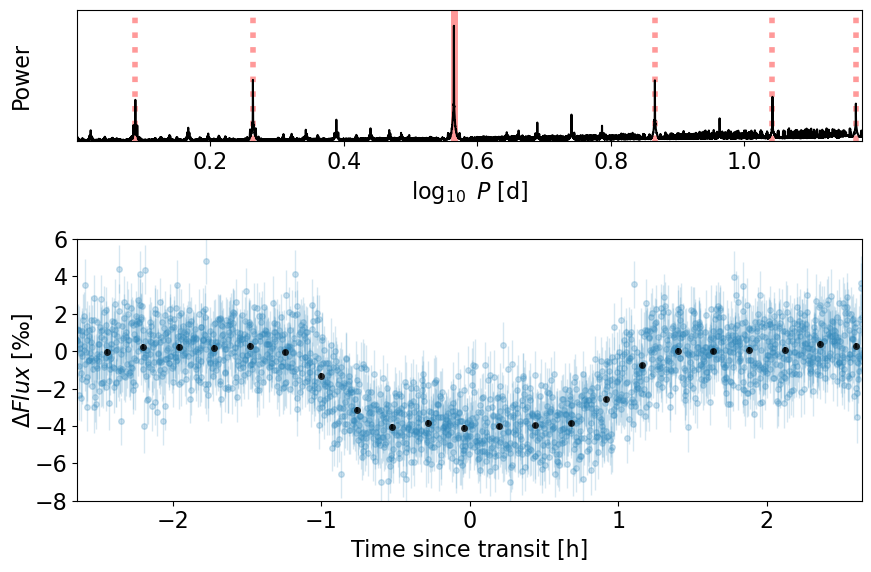

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color="red", lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color="red", lw=4, alpha=0.4)
#ax1.axvline(np.log10(bls_period/4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, "k")
ax1.set_ylim(0,3500)
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [d]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax2.plot(x_fold_*24, y_, ".", alpha=0.25, ms=8, color='#348ABD')
ax2.errorbar(x_fold_*24, y_, yerr=yerr_, fmt="none", color='#348ABD', elinewidth=1, alpha=0.2, capsize=0)
ax2.set_ylim(-8,6)
ax2.set_yticks([-8,-6,-4,-2,0,2,4,6])

# Overplot the phase binned light curve
lcc = lk.LightCurve(time=x_fold_, flux=y_, flux_err=yerr_)
lcc_binned = lcc.bin(time_bin_size=0.01)
ax2.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, capsize=2, alpha=0.8)
ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time since transit [h]")
plt.tight_layout()
#plt.savefig('bls_paper_1199.png',dpi=300,bbox_inches='tight', facecolor='white')

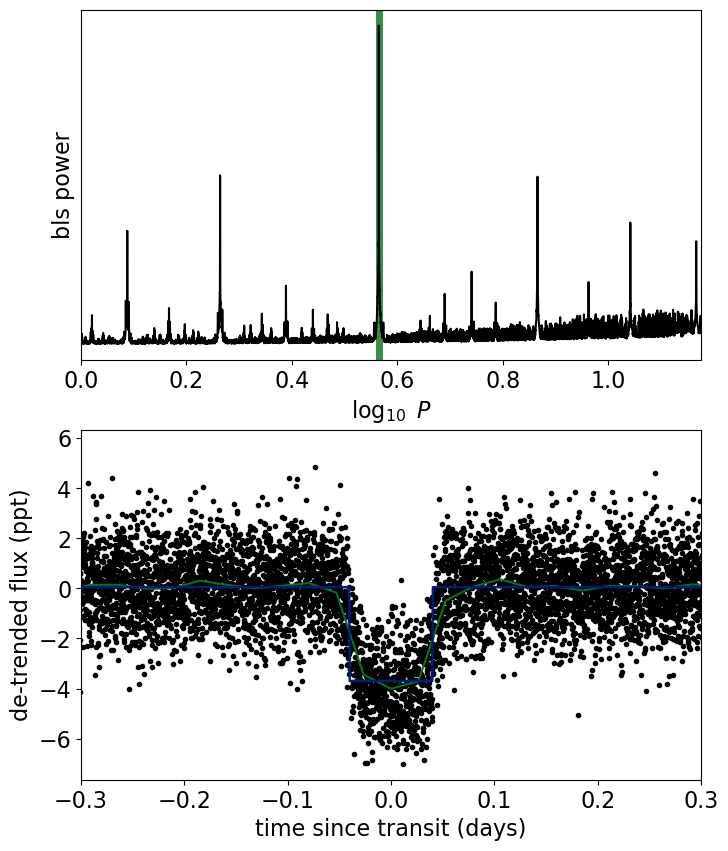

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")

ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel(r"$\log_{10}~ P$")
#ax.set_xlabel('log10 (period)')

# Plot the folded transit
ax = axes[1]
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax.plot(x_fold_, y_, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold_, bins)
num, _ = np.histogram(x_fold_, bins, weights=y_)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux (ppt)")
_ = ax.set_xlabel("time since transit (days)")

# Over-plot the best fit model
x_p = np.linspace(-0.3, 0.3, 1000)
f = bls.model(x_p + bls_t0, bls_period, bls_duration, bls_t0)
ax.plot(x_p, f, lw=1.75)

#plt.savefig('bls_1199.png',dpi=200,bbox_inches='tight')

(-0.12, 0.12)

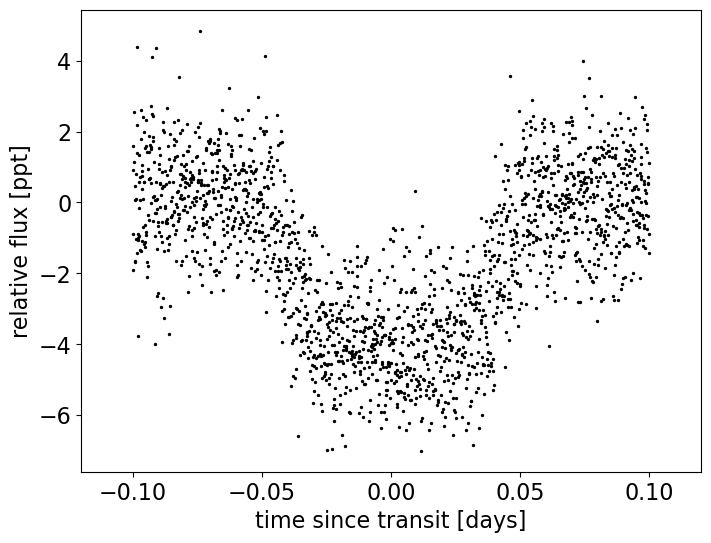

In [21]:
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
plt.xlim(-0.12,0.12)

## SOPHIE RVs

60


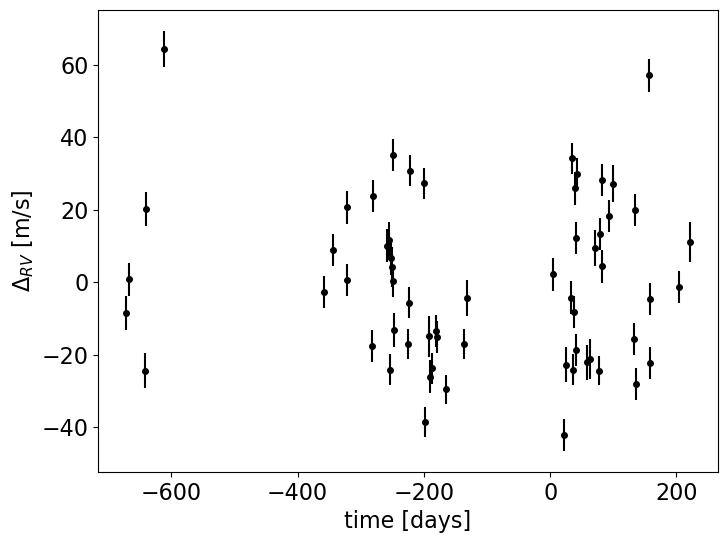

In [22]:
data = pd.read_table('./data/rvs/1199_final_rvs.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err', 'bis(km/s)': 'bis'}, inplace=True)

x_rv = np.array(data.bjd+2400000-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)


plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [23]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print(K, "m/s")

# Stellar parameters from Sousa
M_star = 1.18, 0.02
R_star = 1.45, 0.05

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print('minimum mass=', msini)

[28.38522575] m/s
minimum mass= [76.46697698] earthMass


Periodograms

In [24]:
from astropy.timeseries import LombScargle

In [25]:
# read de BIS data
ls = LombScargle(data.bjd, data.rv, data.err)
ls_bis = LombScargle(data.bjd, data.bis)

frequency, power = ls.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

frequency_bis, power_bis = ls_bis.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

probabilities = [0.1, 0.05, 0.01]
faps = ls.false_alarm_level(probabilities)  
faps_bis = ls_bis.false_alarm_level(probabilities)


In [72]:
# aliases computed in DACE
aliases = [1.374, 1.369, 0.786, 0.784]

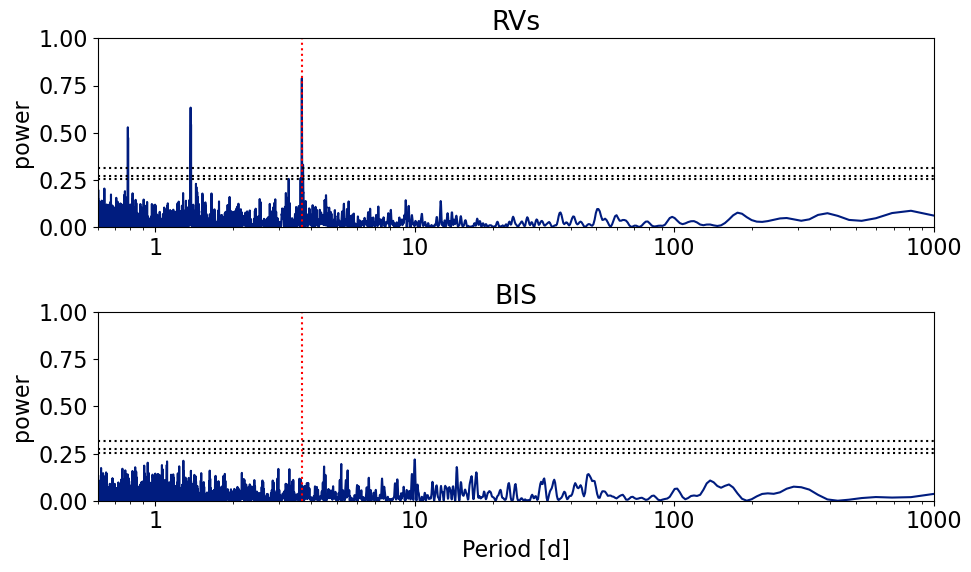

In [26]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(10, 6), tight_layout=True)
axes[0].plot(1/frequency, power, label='RVs') 
axes[1].plot(1/frequency_bis, power_bis, label='BIS') 
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=5, hspace=None)

axes[0].set_xlabel('')
axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlabel('Period [d]')
axes[1].set_xlim(0.6, 1000)
axes[1].set_ylim(0, 1.0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].set_ylabel('power')
axes[1].set_ylabel('power')
axes[0].title.set_text('RVs')
axes[1].title.set_text('BIS')

# overplot the false alarm probabilities
for i, prob in enumerate(probabilities):
    axes[0].axhline(faps[i], ls=':', color='black', label='{}%'.format(prob))
    axes[1].axhline(faps_bis[i], ls=':', color='black', label='{}%'.format(prob))

# plot the 'bls_period' as a vertical line behind the plot
axes[0].axvline(bls_period, ls=':', color='red', label='bls period')
axes[1].axvline(bls_period, ls=':', color='red', label='bls period')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)

plt.show()

BIS vs rvs

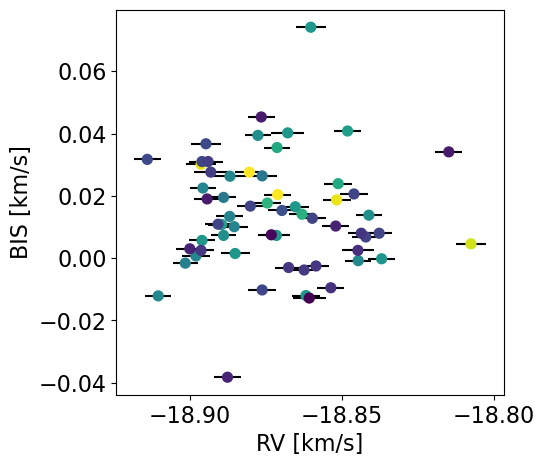

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(data.rv, data.bis, c=data.bjd, cmap='viridis_r', s=50, zorder=10)
# add errorbars on data.rv
ax.errorbar(data.rv, data.bis, xerr=data.err, fmt='none', ecolor='k', markersize=8, zorder=-10)

ax.set_xlabel("RV [km/s]")
ax.set_ylabel("BIS [km/s]")

plt.show()

In [28]:
0.5*np.log(bls_depth * 1e-3)

-2.793537993043475

In [29]:
np.log(np.median(yerr_rv))

1.4816045409242156

## Ground LCs

### KeplerCam

In [30]:
data1 = pd.read_table('./data/photom/TOI1199/TIC99869022.01_UT2021.0213_KeplerCam_B.dat', sep='\s+')
data2 = pd.read_table('./data/photom/TOI1199/TIC99869022.01_UT2021.0413_KeplerCam_B.dat', sep='\s+')
data3 = pd.read_table('./data/photom/TOI1199/TIC99869022.01_UT2021.0213_KeplerCam_z.dat', sep='\s+')
data4 = pd.read_table('./data/photom/TOI1199/TIC99869022.01_UT2021.0413_KeplerCam_z.dat', sep='\s+')
data1.columns

Index(['#', 'Label', 'BJD_TDB', 'rel_flux_T1', 'rel_flux_err_T1', 'AIR',
       'JD_UTC'],
      dtype='object')

In [31]:
#puntos?
print('puntos:', len(data1)+len(data2)+len(data3)+len(data4))
# texp?
print('texp:', np.median(np.diff(data1['BJD_TDB']))*24*60*60)
texp_keplercam = None

puntos: 732
texp: 105.06239533424377


In [32]:
data1['flux'] = ((data1['rel_flux_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux'] = ((data2['rel_flux_T1']/(data2['rel_flux_T1'].median())))*1e3
data3['flux'] = ((data3['rel_flux_T1']/(data3['rel_flux_T1'].median())))*1e3
data4['flux'] = ((data4['rel_flux_T1']/(data4['rel_flux_T1'].median())))*1e3

data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux_err'] = ((data2['rel_flux_err_T1']/(data2['rel_flux_T1'].median())))*1e3
data3['flux_err'] = ((data3['rel_flux_err_T1']/(data3['rel_flux_T1'].median())))*1e3
data4['flux_err'] = ((data4['rel_flux_err_T1']/(data4['rel_flux_T1'].median())))*1e3

data1['time'] = data1['BJD_TDB']-2457000-ref_time
data2['time'] = data2['BJD_TDB']-2457000-ref_time
data3['time'] = data3['BJD_TDB']-2457000-ref_time
data4['time'] = data4['BJD_TDB']-2457000-ref_time

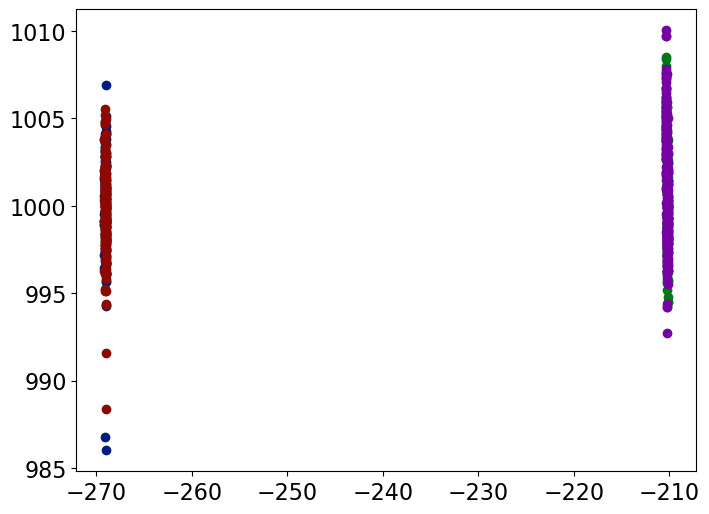

In [33]:
# Lest plot them together
plt.plot(data1['time'], data1['flux'], 'o', label='2021.0213_KeplerCam_B')
plt.plot(data2['time'], data2['flux'], 'o', label='2021.0413_KeplerCam_B')
plt.plot(data3['time'], data3['flux'], 'o', label='2021.0213_KeplerCam_z')
plt.plot(data4['time'], data4['flux'], 'o', label='2021.0413_KeplerCam_z')
#plt.xlim(-211, -210)
#plt.xlim(-269.2,-268.5)
plt.show()

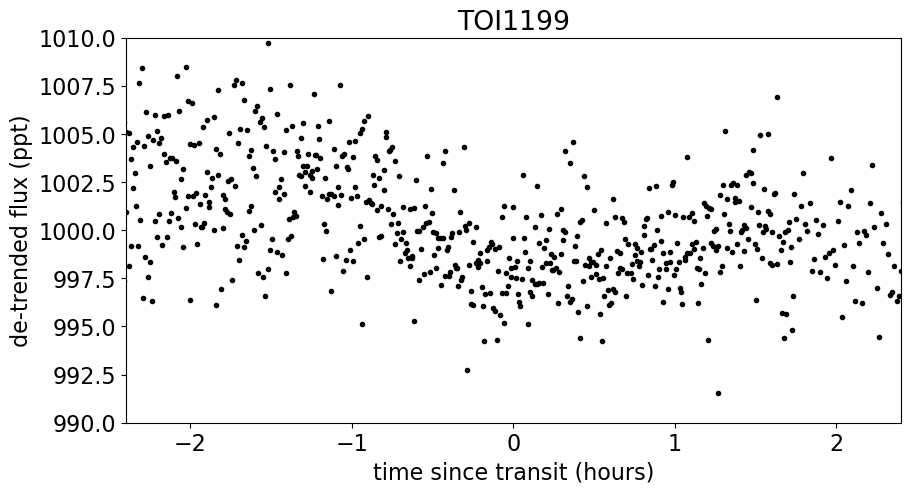

In [34]:
# Plot the folded data, con los parametros del BLS
data1_fold = (data1['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data2_fold = (data2['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data3_fold = (data3['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data4_fold = (data4['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

plt.figure(figsize=(10, 5))
plt.plot(data1_fold*24, data1['flux'], ".k", label="data1", zorder=-1000)
plt.plot(data2_fold*24, data2['flux'], ".k", label="data2", zorder=-1000)
plt.plot(data3_fold*24, data3['flux'], ".k", label="data3", zorder=-1000)
plt.plot(data4_fold*24, data4['flux'], ".k", label="data4", zorder=-1000)

plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.ylim(990,1010)
plt.title("TOI1199")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [35]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], bls_period, bls_duration, bls_t0)
oot_mask2 = bls.transit_mask(data2['time'], bls_period, bls_duration, bls_t0)
oot_mask3 = bls.transit_mask(data3['time'], bls_period, bls_duration, bls_t0)
oot_mask4 = bls.transit_mask(data4['time'], bls_period, bls_duration, bls_t0)

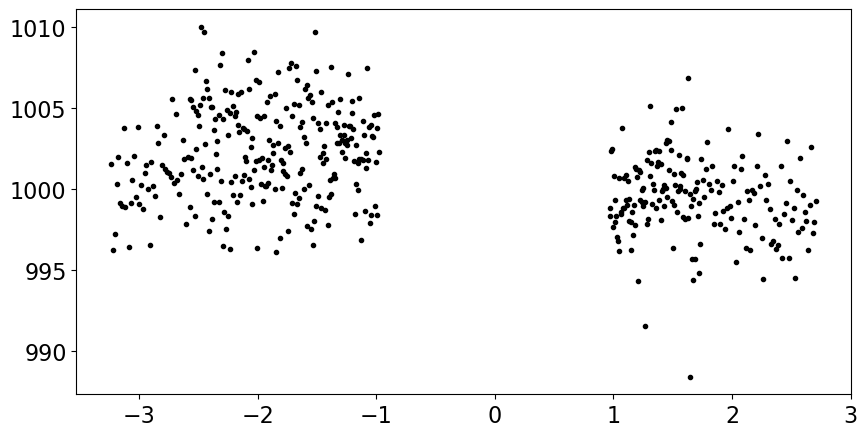

In [36]:
# checking the oot mask
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".k", label="data1", zorder=-1000)
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2], ".k", label="data2", zorder=-1000)
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3], ".k", label="data3", zorder=-1000)
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4], ".k", label="data4", zorder=-1000)

In [37]:
# fitemos un pol grado 2 a los datos oot
# separando por bandas B y z
x_oot_B = np.concatenate(((data1_fold*24)[~oot_mask1], (data2_fold*24)[~oot_mask2]), axis=None)
x_oot_z = np.concatenate(((data3_fold*24)[~oot_mask3], (data4_fold*24)[~oot_mask4] ), axis=None)

y_oot_B = np.concatenate((data1['flux'][~oot_mask1], data2['flux'][~oot_mask2]), axis=None)
y_oot_z = np.concatenate((data3['flux'][~oot_mask3], data4['flux'][~oot_mask4]), axis=None)

z_B = np.polyfit(x_oot_B, y_oot_B, 2) 
z_z = np.polyfit(x_oot_z, y_oot_z, 2) 
def pol_B(x):
    return np.asarray(z_B[0]*x**2 + z_B[1]*x + z_B[2])

def pol_z(x):
    return np.asarray(z_z[0]*x**2 + z_z[1]*x + z_z[2])

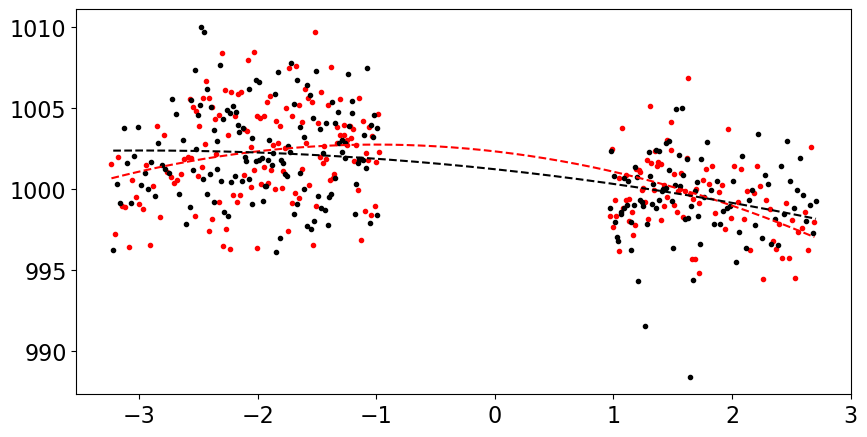

In [38]:
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".r", label="data1", zorder=-1000)
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2], ".r", label="data2", zorder=-1000)
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3], ".k", label="data3", zorder=-1000)
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4], ".k", label="data4", zorder=-1000)
x_plot_B = np.linspace(np.min(x_oot_B), np.max(x_oot_B), 1000)
x_plot_z = np.linspace(np.min(x_oot_z), np.max(x_oot_z), 1000)

plt.plot(x_plot_B, pol_B(x_plot_B), color="r", linestyle="--")
plt.plot(x_plot_z, pol_z(x_plot_z), color="k", linestyle="--")

#plt.savefig('ajuste_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')

In [39]:
from scipy import stats
x_conc_B = np.concatenate((data1_fold*24, data2_fold*24), axis=None)
x_conc_z = np.concatenate((data3_fold*24, data4_fold*24), axis=None)
y_conc_B = np.concatenate(((np.asarray(data1['flux'])/pol_B(data1_fold*24)-1)*1e3, (np.asarray(data2['flux'])/pol_B(data2_fold*24)-1)*1e3), axis=None)
y_conc_z = np.concatenate(((np.asarray(data3['flux'])/pol_z(data3_fold*24)-1)*1e3, (np.asarray(data4['flux'])/pol_z(data4_fold*24)-1)*1e3), axis=None)

yerr_conc_B = np.concatenate((data1['flux_err'], data2['flux_err']), axis=None)
yerr_conc_z = np.concatenate((data3['flux_err'], data4['flux_err']), axis=None)

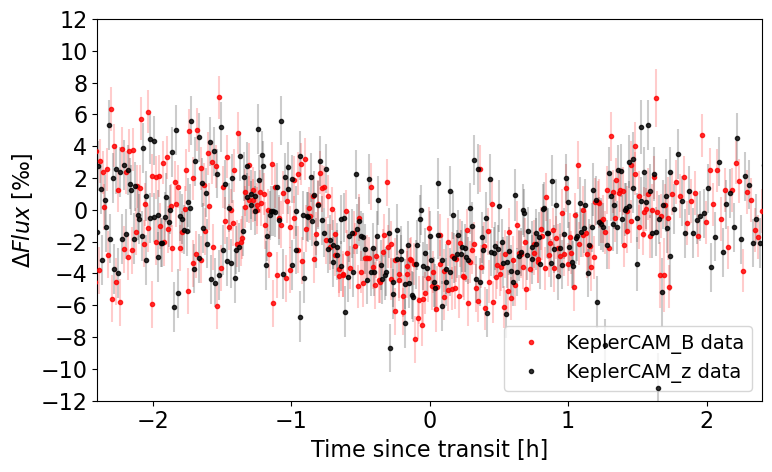

In [40]:
#replot dividing by polynomial
plt.figure(figsize=(8, 5))
# Plot the data
plt.plot(x_conc_B, y_conc_B, 'o', ms=3, color='r', label='KeplerCAM_B data', zorder=1000, alpha=0.8)
plt.errorbar(x_conc_B, y_conc_B, yerr=yerr_conc_B, fmt="none", color='r', capsize=0, zorder=-1000, alpha=0.2)
plt.plot(x_conc_z, y_conc_z, 'o', ms=3, color='k', label='KeplerCAM_z data', zorder=1000, alpha=0.8)
plt.errorbar(x_conc_z, y_conc_z, yerr=yerr_conc_z, fmt="none", color='k', capsize=0, zorder=-1000, alpha=0.2)

plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.yticks([-12,-10,-8, -6, -4, -2,0,2,4,6,8,10,12])
plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-12, 12)
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()


In [41]:
# datos de keplercam finales
x_keplercam_B = np.concatenate((data1['time'], data2['time']), axis=None)
x_keplercam_z = np.concatenate((data3['time'], data4['time']), axis=None)

y_keplercam_B = y_conc_B
yerr_keplercam_B = yerr_conc_B
y_keplercam_z = y_conc_z
yerr_keplercam_z = yerr_conc_z

### MuSCAT2

In [42]:
data5 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427_zs_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')
data6 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427._g_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')
data7 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427._i_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')
data8 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427._r_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')

# Convert time to the same reference time as tess and flux to ppt
data5['bjd'] = data5['bjd']-2457000-ref_time
data6['bjd'] = data6['bjd']-2457000-ref_time
data7['bjd'] = data7['bjd']-2457000-ref_time
data8['bjd'] = data8['bjd']-2457000-ref_time
data5['flux'] = np.ascontiguousarray(1e3 * (data5['flux'] - 1.0), dtype=np.float64) 
data6['flux'] = np.ascontiguousarray(1e3 * (data6['flux'] - 1.0), dtype=np.float64)
data7['flux'] = np.ascontiguousarray(1e3 * (data7['flux'] - 1.0), dtype=np.float64)
data8['flux'] = np.ascontiguousarray(1e3 * (data8['flux'] - 1.0), dtype=np.float64)
data5['flux_err'] = np.ascontiguousarray(1e3 * (data5['flux_err']), dtype=np.float64) 
data6['flux_err'] = np.ascontiguousarray(1e3 * (data6['flux_err']), dtype=np.float64)
data7['flux_err'] = np.ascontiguousarray(1e3 * (data7['flux_err']), dtype=np.float64)
data8['flux_err'] = np.ascontiguousarray(1e3 * (data8['flux_err']), dtype=np.float64)

In [43]:
# Texp?
print(np.median(np.diff(data8['bjd']))*24*60*60)
texp_muscat = None

11.015751957893372


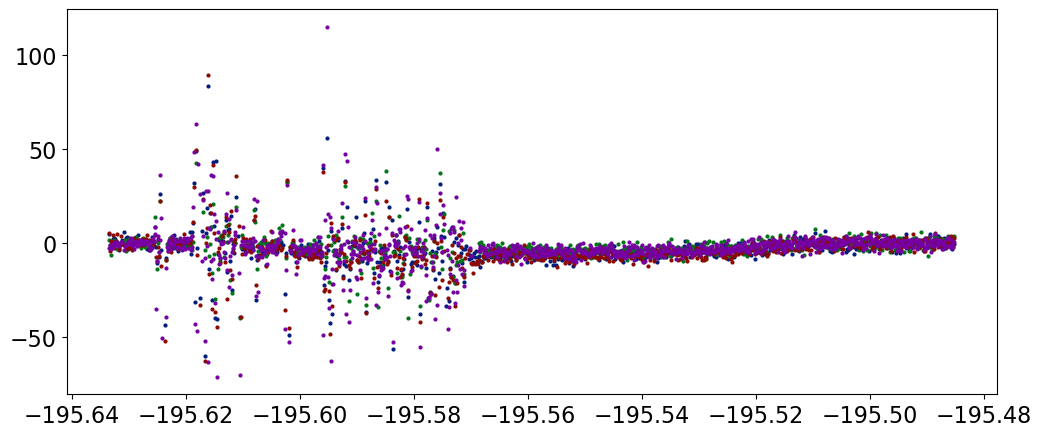

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(data5.bjd, data5.flux, 'o', label='z', ms=2)
plt.plot(data6.bjd, data6.flux, 'o', label='z', ms=2)
plt.plot(data7.bjd, data7.flux, 'o', label='z', ms=2)
plt.plot(data8.bjd, data8.flux, 'o', label='z', ms=2)
plt.show()

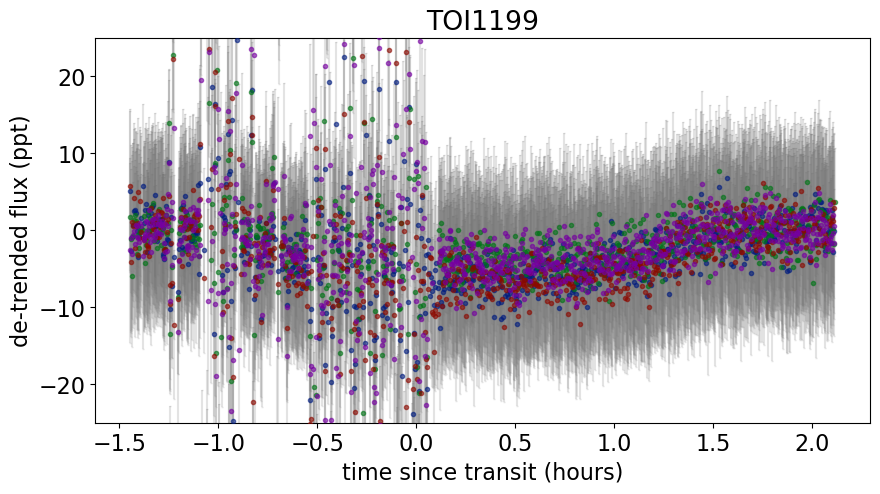

In [45]:
# Plot the folded data, con los parametros del BLS
data5_fold = (data5['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data6_fold = (data6['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data7_fold = (data7['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data8_fold = (data8['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

muscat_time = pd.concat([data5_fold, data6_fold, data7_fold, data8_fold], ignore_index=True)
# datos finales muscat
x_muscat_zs_ = np.ascontiguousarray(data5['bjd'], dtype=np.float64)
x_muscat_g_ = np.ascontiguousarray(data6['bjd'], dtype=np.float64)
x_muscat_i_ = np.ascontiguousarray(data7['bjd'], dtype=np.float64)
x_muscat_r_ = np.ascontiguousarray(data8['bjd'], dtype=np.float64)
y_muscat_zs_ = np.ascontiguousarray(data5['flux'], dtype=np.float64)
y_muscat_g_ = np.ascontiguousarray(data6['flux'], dtype=np.float64)
y_muscat_i_ = np.ascontiguousarray(data7['flux'], dtype=np.float64)
y_muscat_r_ = np.ascontiguousarray(data8['flux'], dtype=np.float64)
yerr_muscat_zs_ = np.ascontiguousarray(data5['flux_err'], dtype=np.float64)
yerr_muscat_g_ = np.ascontiguousarray(data6['flux_err'], dtype=np.float64)
yerr_muscat_i_ = np.ascontiguousarray(data7['flux_err'], dtype=np.float64)
yerr_muscat_r_ = np.ascontiguousarray(data8['flux_err'], dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(data5_fold*24, y_muscat_zs_, '.', label='Muscat2_zs', alpha=0.6, zorder=100)
plt.errorbar(data5_fold*24, y_muscat_zs_, yerr=yerr_muscat_zs_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data6_fold*24, y_muscat_g_, '.', label='Muscat2_g', alpha=0.6, zorder=100)
plt.errorbar(data6_fold*24, y_muscat_g_, yerr=yerr_muscat_g_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data7_fold*24, y_muscat_i_, '.', label='Muscat2_i', alpha=0.6, zorder=100)
plt.errorbar(data7_fold*24, y_muscat_i_, yerr=yerr_muscat_i_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data8_fold*24, y_muscat_r_, '.', label='Muscat2_r', alpha=0.6, zorder=100)
plt.errorbar(data8_fold*24, y_muscat_r_, yerr=yerr_muscat_r_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)

plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
#plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-25,25)
plt.title("TOI1199")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [46]:
# mask the first half of the transit
x_muscat_zs = x_muscat_zs_[data5_fold*24>0.10]
x_muscat_g = x_muscat_g_[data6_fold*24>0.10]
x_muscat_i = x_muscat_i_[data7_fold*24>0.10]
x_muscat_r = x_muscat_r_[data8_fold*24>0.10]
y_muscat_zs = y_muscat_zs_[data5_fold*24>0.10]
y_muscat_g = y_muscat_g_[data6_fold*24>0.10]
y_muscat_i = y_muscat_i_[data7_fold*24>0.10]
y_muscat_r = y_muscat_r_[data8_fold*24>0.10]
yerr_muscat_zs = yerr_muscat_zs_[data5_fold*24>0.10]
yerr_muscat_g = yerr_muscat_g_[data6_fold*24>0.10]
yerr_muscat_i = yerr_muscat_i_[data7_fold*24>0.10]
yerr_muscat_r = yerr_muscat_r_[data8_fold*24>0.10]

print(len(x_muscat_zs), len(y_muscat_zs), len(yerr_muscat_zs))
print(len(x_muscat_g), len(y_muscat_g), len(yerr_muscat_g))
print(len(x_muscat_i), len(y_muscat_i), len(yerr_muscat_i))
print(len(x_muscat_r), len(y_muscat_r), len(yerr_muscat_r))


453 453 453
445 445 445
452 452 452
654 654 654


# LC dataset

In [47]:
from collections import OrderedDict

datasets = OrderedDict(
    [
        ("tess", [x, y, yerr, texp]),
        ("keplercam_B", [x_keplercam_B, y_keplercam_B, yerr_keplercam_B, texp_keplercam]),
        ("keplercam_z", [x_keplercam_z, y_keplercam_z, yerr_keplercam_z, texp_keplercam]),
        ('muscat_zs', [x_muscat_zs, y_muscat_zs, yerr_muscat_zs, texp_muscat]),
        ('muscat_g', [x_muscat_g, y_muscat_g, yerr_muscat_g, texp_muscat]),
        ('muscat_i', [x_muscat_i, y_muscat_i, yerr_muscat_i, texp_muscat]),
        ('muscat_r', [x_muscat_r, y_muscat_r, yerr_muscat_r, texp_muscat])
    ]
)

In [48]:
for n, (name, (x_, y_, yerr_, texp_)) in enumerate(datasets.items()):
    print(n, name, len(x_), len(y_), len(yerr_), type(x_), type(y_), type(yerr_))

0 tess 1894 1894 1894 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
1 keplercam_B 366 366 366 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
2 keplercam_z 366 366 366 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
3 muscat_zs 453 453 453 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
4 muscat_g 445 445 445 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
5 muscat_i 452 452 452 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
6 muscat_r 654 654 654 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


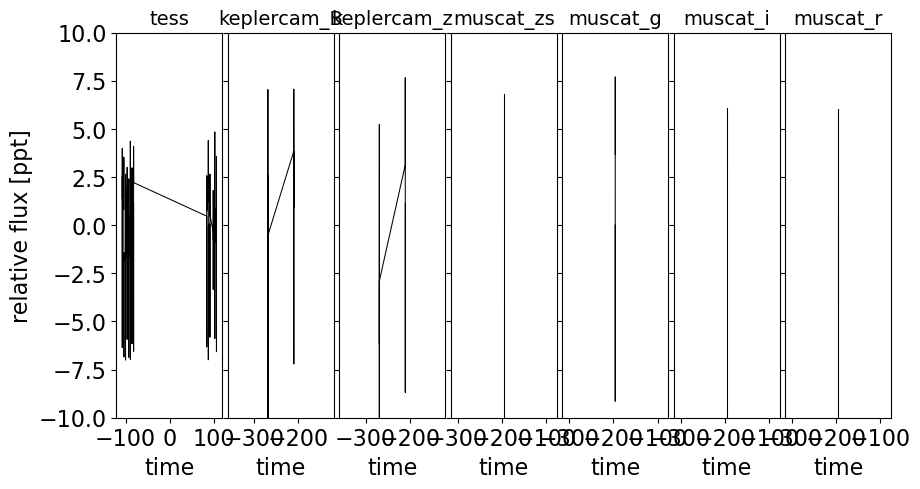

In [49]:
fig, axes = plt.subplots(1, len(datasets), sharey=True, figsize=(10, 5))

for i, (name, (t, y, _, _)) in enumerate(datasets.items()):
    ax = axes[i]
    ax.plot(t, y, "k", lw=0.75, label=name)
    ax.set_xlabel("time")
    ax.set_title(name, fontsize=14)

    x_mid = 0.5 * (t.min() + t.max())
    ax.set_xlim(x_mid - 120, x_mid + 120)
axes[0].set_ylim(-10, 10)
fig.subplots_adjust(wspace=0.05)
_ = axes[0].set_ylabel("relative flux [ppt]")

# Joint model

In [50]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 500)

for i in range(10):
    with pm.Model() as model:
        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value[0]), sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        # b = pmx.UnitUniform("b")
        log_ror = pm.Normal("log_ror", mu=0.5*np.log(bls_depth * 1e-3), sd=1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        b = xo.ImpactParameter('b', ror)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        # comentar las proximas tres lineas para versión con e=0 fixed
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        transit_obs = dict()
        lc_pred = dict()
        for n, (name, (x_, y_, yerr_, texp_)) in enumerate(datasets.items()):
            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sd=5.0)
                # The limb darkening
                u_star = xo.QuadLimbDark("u_star")
                star = xo.LimbDarkLightCurve(u_star)

                # Transit jitter
                logs = pm.Normal("logs", mu=np.log(np.median(yerr_)), sd=1)
                
                # Keep track of the parameters for optimization
                parameters[name] = [mean, u_star, logs]
            
            # The light curve model
            def lc_model(mean, star, r_pl, texp, t):
                return tt.sum((star.get_light_curve(orbit=orbit, r=r_pl, 
                                                        t=t, texp=texp)* 1e3), axis=-1) + mean

            #lc_model = partial(lc_model, mean, star, ror, texp)
            lc_models[name] = lc_model(mean, star, r_pl, texp_, x_)

            # The likelihood for the light curve
            err_lc = tt.sqrt(yerr_**2 + tt.exp(2*logs)) 
            transit_obs = pm.Normal(f"{name}_obs", mu=lc_models[name], sd=err_lc, observed=y_) 

            # # Compute and save the phased light curve models
            pm.Deterministic(f"{name}_lc_pred", 1e3 * star.get_light_curve(orbit=orbit, 
                                                                    r=r_pl, t=t0 + phase_lc, 
                                                                    texp=texp_)[..., 0],)

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name] + [ecs, b, log_period])
            map_soln = pmx.optimize(map_soln, parameters[name] + [log_sigma_rv, trend, log_sigma_rv])
        map_soln = pmx.optimize(map_soln)

        extras = dict()
        for name in datasets:
            extras[name] = pmx.eval_in_model(lc_models[name], map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = pmx.eval_in_model(lc_models[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")

        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]

message: Optimization terminated successfully.
logp: -13622.646290013881 -> -13084.87382445036


message: Optimization terminated successfully.
logp: -13084.87382445036 -> -12952.274430112573


message: Optimization terminated successfully.
logp: -12952.274430112573 -> -12839.914232409546


message: Optimization terminated successfully.
logp: -12839.914232409546 -> -12692.792222447208


message: Optimization terminated successfully.
logp: -12692.792222447208 -> -12554.240479967802


message: Optimization terminated successfully.
logp: -12554.240479967802 -> -12408.035089712661


message: Optimization terminated successfully.
logp: -12408.035089712661 -> -12191.53264352266


message: Desired error not necessarily achieved due to precision loss.
logp: -12191.53264352266 -> -11964.525818515305


message: Desired error not necessarily achieved due to precision loss.
logp: -11964.525818515305 -> -11930.071517129147


message: Desired error not necessarily achieved due to precision loss.
logp: -11930.071517129147 -> -11903.515947423311


message: Desired error not necessarily achieved due to precision loss.
logp: -11903.515947423311 -> -11902.754605768416


message: Desired error not necessarily achieved due to precision loss.
logp: -11902.754605768416 -> -11882.79945540308


message: Optimization terminated successfully.
logp: -11882.799455403077 -> -11882.602159955703


message: Desired error not necessarily achieved due to precision loss.
logp: -11882.602159955703 -> -11880.96671600128


message: Optimization terminated successfully.
logp: -11880.96671600128 -> -11880.93168133178


message: Desired error not necessarily achieved due to precision loss.
logp: -11880.931681331778 -> -11879.495262381282


message: Optimization terminated successfully.
logp: -11879.495262381282 -> -11879.494853027196


message: Desired error not necessarily achieved due to precision loss.
logp: -11879.494853027194 -> -11875.771166674169


message: Desired error not necessarily achieved due to precision loss.
logp: -11875.771166674169 -> -11875.769818358522


message: Desired error not necessarily achieved due to precision loss.
logp: -11875.769818358522 -> -11874.981182189893


message: Desired error not necessarily achieved due to precision loss.
logp: -11874.981182189891 -> -11874.978194950976


message: Desired error not necessarily achieved due to precision loss.
logp: -11874.978194950976 -> -11671.280731113719


Sigma clipped 0 tess light curve points
Sigma clipped 2 keplercam_B light curve points
Sigma clipped 1 keplercam_z light curve points
Sigma clipped 0 muscat_zs light curve points
Sigma clipped 0 muscat_g light curve points
Sigma clipped 0 muscat_i light curve points
Sigma clipped 0 muscat_r light curve points


MAP rv model

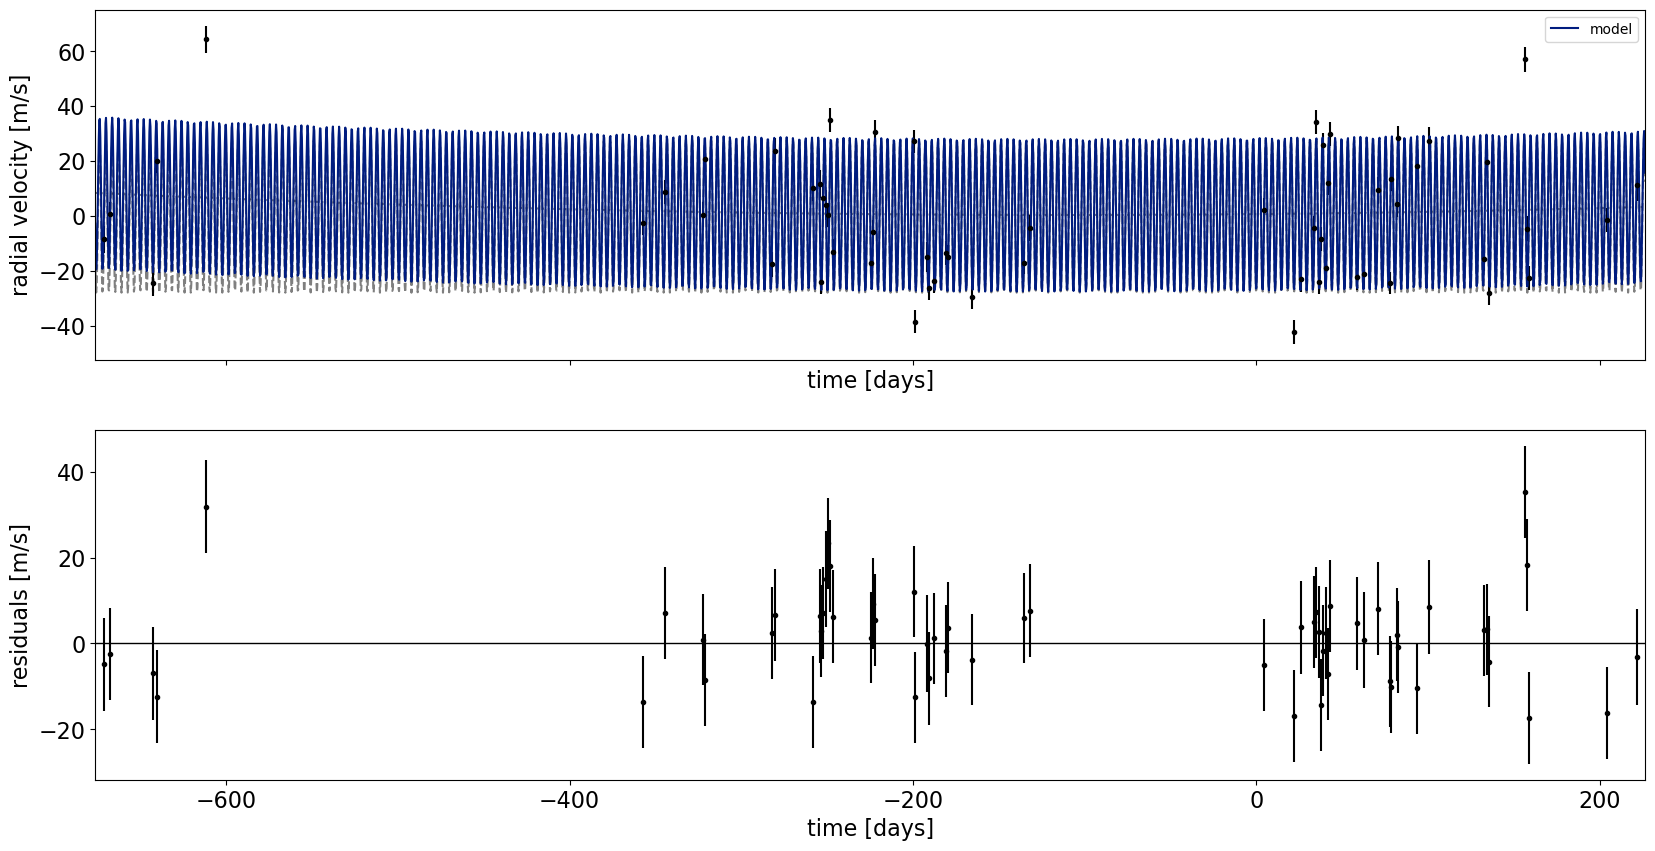

In [51]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln)

In [52]:
# extras['tess']

MAP LCs models

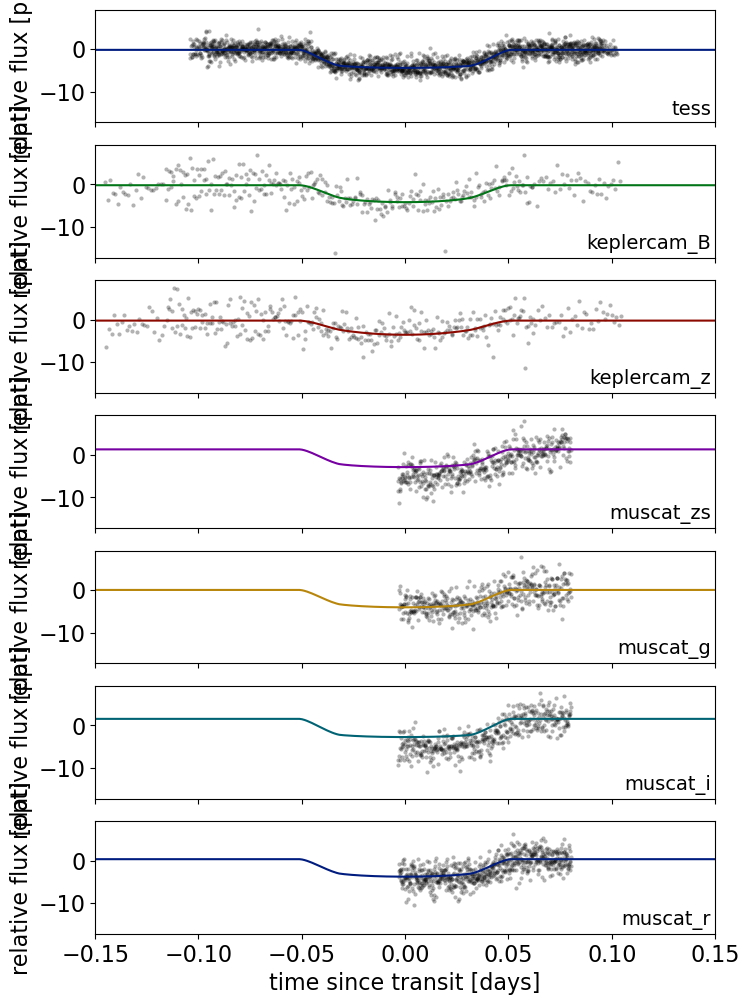

In [53]:
fig, axes = plt.subplots(7, sharex=True, sharey=True, figsize=(8, 12))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y  - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(
        phase_lc, map_soln[name+'_lc_pred'] - map_soln[f"{name}_mean"], f"C{n}", label=name
    )
    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

#plt.savefig('lcs_fits.png', dpi=200, bbox_inches='tight')

In [54]:
# pm.model_to_graphviz(model)

# Sampling

In [55]:
with model:
    trace = pmx.sample(
        tune=4000, #1500,
        draws=4000, #1000,
        start=map_soln,
        cores=2, #4
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],#, 261136679, 261136680],
        init="adapt_full",
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [muscat_r_logs, muscat_r_u_star, muscat_r_mean, muscat_i_logs, muscat_i_u_star, muscat_i_mean, muscat_g_logs, muscat_g_u_star, muscat_g_mean, muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean, keplercam_z_logs, keplercam_z_u_star, keplercam_z_mean, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean, tess_logs, tess_u_star, tess_mean, trend, log_sigma_rv, ecs, b, log_ror, log_period, log_m_pl, t0, r_star, m_star]
NUTS: [muscat_r_logs, muscat_r_u_star, muscat_r_mean, muscat_i_logs, muscat_i_u_star, muscat_i_mean, muscat_g_logs, muscat_g_u_star, muscat_g_mean, muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean, keplercam_z_logs, keplercam_z_u_star, keplercam_z_mean, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean, tess_logs, tess_u_star, tess_mean, trend, log_sigma_rv, ecs, b, log_ror, log_period, log_m_pl, t0, r_star, m_star]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 2468 seconds.


In [73]:
import arviz as az
# version con e libre
# az.to_netcdf(trace, 'trace.toi1199_glcs2.save')
## trace = az.from_netcdf('trace.toi1199.save')

# version con e=0 fixed
# az.to_netcdf(trace, 'trace.toi1199_noecc.save')
# trace = az.from_netcdf('trace.toi1199_noecc.save')

'trace.toi1199_glcs2.save'

In [74]:
#trace.posterior.data_vars
# print only the names
for n, var in enumerate(trace.posterior.data_vars):
    if n<=15:
        print(n, var)


0 t0
1 log_m_pl
2 log_period
3 log_ror
4 log_sigma_rv
5 trend
6 tess_mean
7 tess_logs
8 keplercam_B_mean
9 keplercam_B_logs
10 keplercam_z_mean
11 keplercam_z_logs
12 muscat_zs_mean
13 muscat_zs_logs
14 muscat_g_mean
15 muscat_g_logs


Summary stats

In [75]:
az.summary(trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.68, round_to=6,
           var_names=[
               't0',
               'log_m_pl',
               'log_period',
               'log_ror',
               'log_sigma_rv',
               'trend',
               'tess_mean',
               'tess_logs',
               'keplercam_B_mean',
               'keplercam_B_logs',
               'keplercam_z_mean',
               'keplercam_z_logs',
               'muscat_zs_mean',
               'muscat_zs_logs',
               'muscat_g_mean',
               'muscat_g_logs',
               'muscat_i_mean',
               'muscat_i_logs',
               'muscat_r_mean',
               'muscat_r_logs',
               'm_star',
               'r_star',
               'ror',
               'r_pl',
               'b',
               'm_pl',
               'period',
               'ecs',
               'ecc',
               'omega',
               'tess_u_star',
               'keplercam_B_u_star',
               'keplercam_z_u_star',
               'muscat_zs_u_star',
               'muscat_g_u_star',
               'muscat_i_u_star',
               'muscat_r_u_star',
           ])

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,-107.450081,0.000473,-107.450526,-107.449585,0.000005,0.000003,10109.305474,5585.896559,1.001347,-107.450084,0.000473
log_m_pl,4.309062,0.076224,4.233508,4.382512,0.000763,0.000540,10348.884111,6029.545032,1.000646,4.312195,0.076219
log_period,1.300594,0.000003,1.300590,1.300597,0.000000,0.000000,10509.821699,6260.774752,1.001129,1.300594,0.000003
log_ror,-2.701010,0.019916,-2.722771,-2.684173,0.000283,0.000200,4895.461947,5288.933358,1.000656,-2.702621,0.019914
log_sigma_rv,2.320660,0.115117,2.207006,2.437582,0.001178,0.000836,9555.863342,6065.623371,1.000813,2.318753,0.115109
trend[0],0.000027,0.000019,0.000008,0.000046,0.000000,0.000000,9890.999399,6265.288991,0.999783,0.000027,0.000019
trend[1],-0.005921,0.006420,-0.012403,0.000191,0.000064,0.000060,10029.686967,5998.970926,0.999895,-0.005971,0.006419
trend[2],0.643077,0.918644,-0.234643,1.563588,0.009142,0.008883,10116.227999,6117.261084,1.000021,0.649067,0.918586
tess_mean,0.152096,0.041794,0.113391,0.195723,0.000399,0.000290,10958.016749,6372.508959,0.999954,0.152578,0.041792
tess_logs,-1.831917,0.449851,-2.118101,-1.284977,0.005827,0.004514,7811.233756,4667.782524,1.000413,-1.765890,0.449823


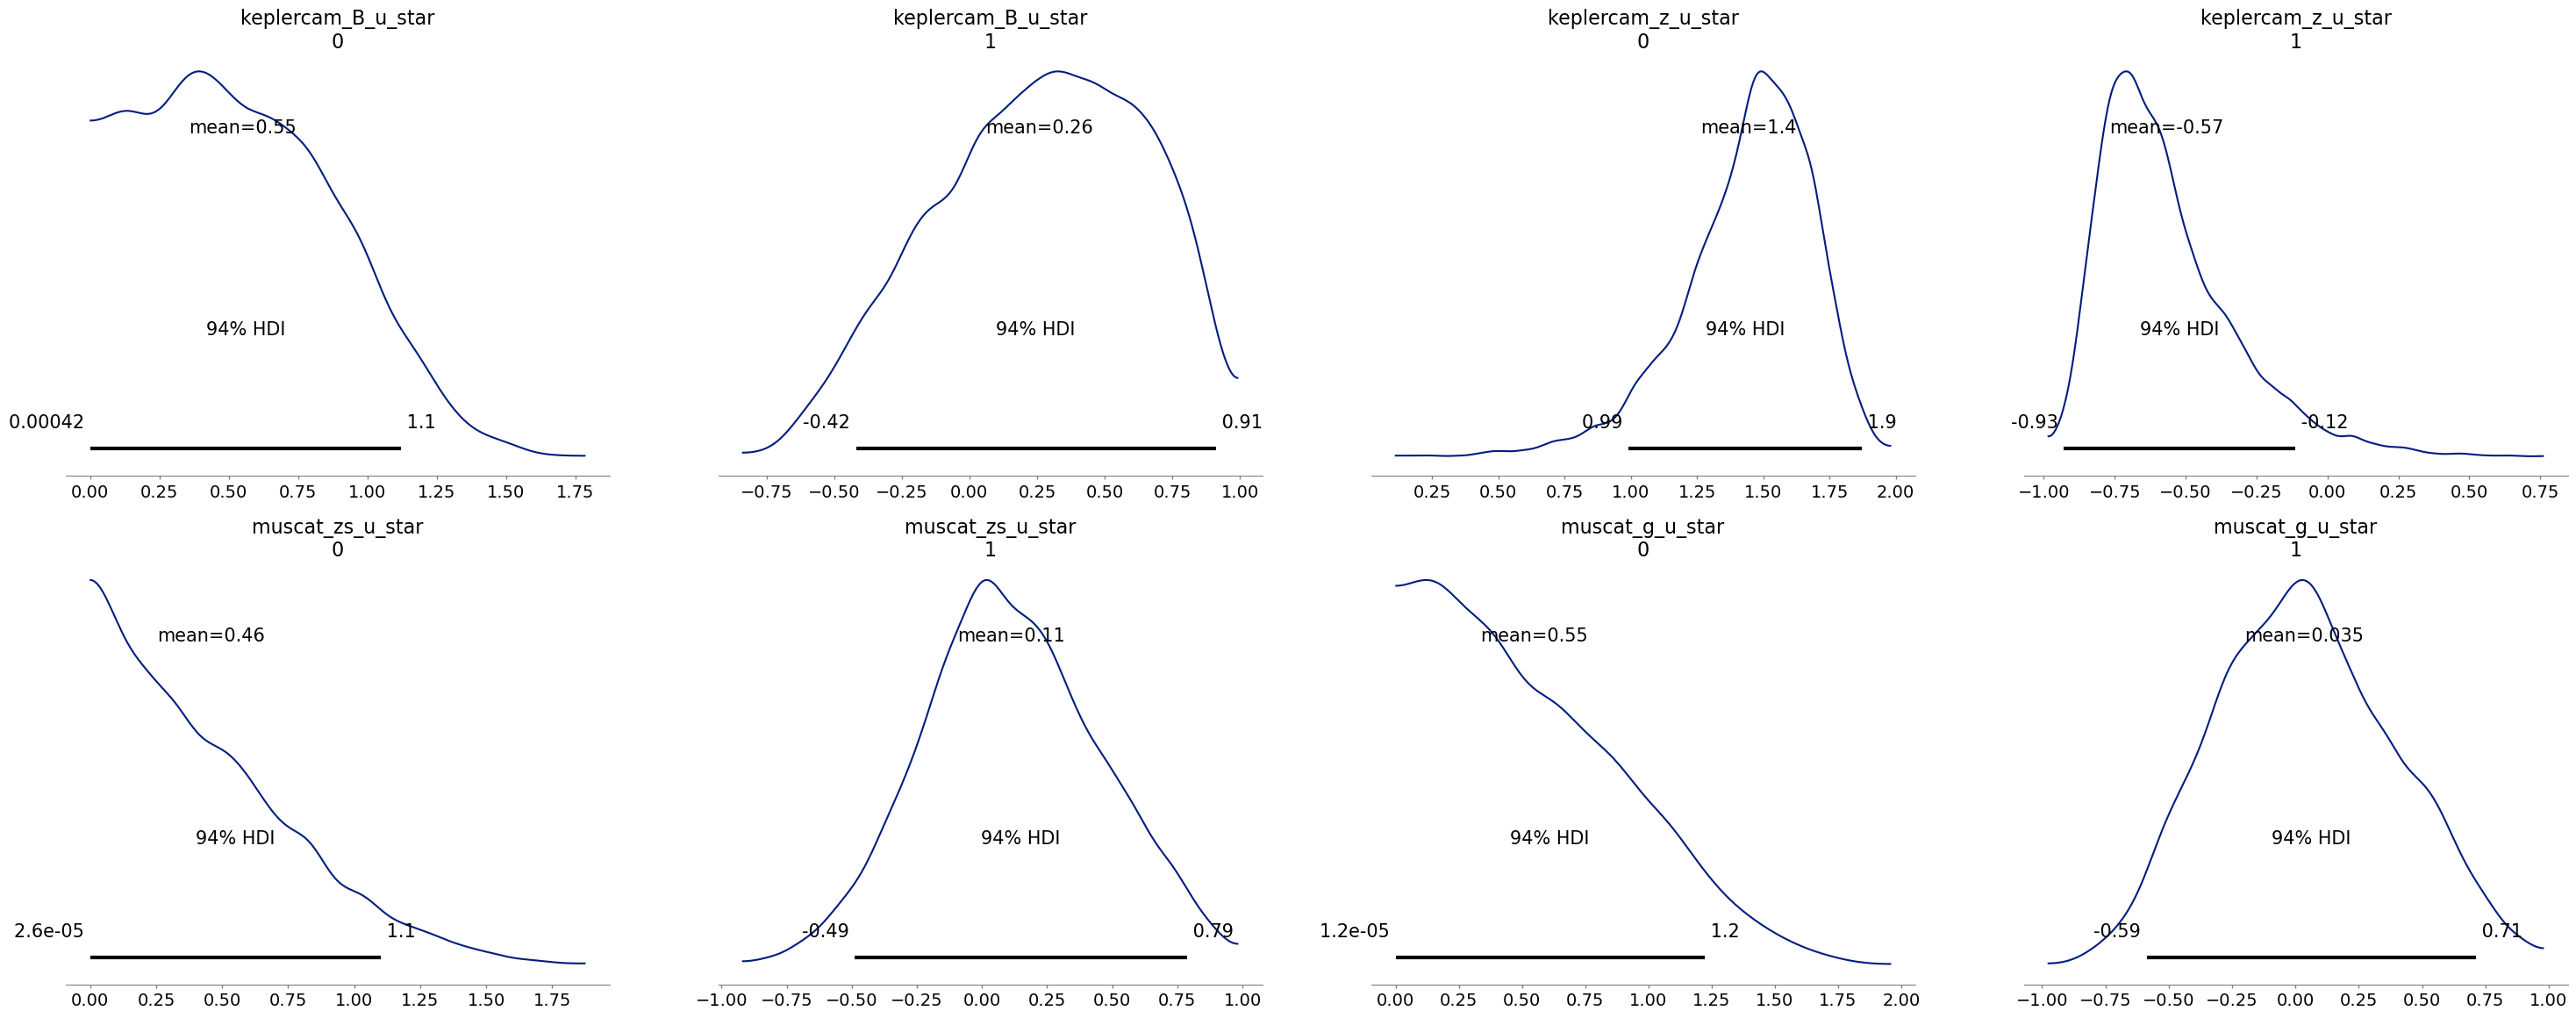

In [79]:
az.plot_posterior(trace, var_names=['keplercam_B_u_star', 'keplercam_z_u_star', 'muscat_zs_u_star', 'muscat_g_u_star'])
#plt.savefig('ustar_posteriors.png', dpi=200, bbox_inches='tight')

In [60]:
from uncertainties import ufloat
from uncertainties.umath import *

logsigma_rv_mean = trace.posterior["log_sigma_rv"].mean().item()
logsigma_rv = ufloat(logsigma_rv_mean, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
tess_jitter_median = trace.posterior['tess_logs'].median().item()
tess_jitter = ufloat(tess_jitter_median, trace.posterior['tess_logs'].std().item())
tess_jitter_val = np.e**tess_jitter
keplercam_B_jitter_median = trace.posterior['keplercam_B_logs'].median().item()
keplercam_B_jitter = ufloat(keplercam_B_jitter_median, trace.posterior['keplercam_B_logs'].std().item())
keplercam_B_jitter_val = np.e**keplercam_B_jitter
keplercam_z_jitter_median = trace.posterior['keplercam_z_logs'].median().item()
keplercam_z_jitter = ufloat(keplercam_z_jitter_median, trace.posterior['keplercam_z_logs'].std().item())
keplercam_z_jitter_val = np.e**keplercam_z_jitter
muscat_zs_jitter_median = trace.posterior['muscat_zs_logs'].median().item()
muscat_zs_jitter = ufloat(muscat_zs_jitter_median, trace.posterior['muscat_zs_logs'].std().item())
muscat_zs_jitter_val = np.e**muscat_zs_jitter
# same for g, i, r
muscat_g_jitter_median = trace.posterior['muscat_g_logs'].median().item()
muscat_g_jitter = ufloat(muscat_g_jitter_median, trace.posterior['muscat_g_logs'].std().item())
muscat_g_jitter_val = np.e**muscat_g_jitter
muscat_i_jitter_median = trace.posterior['muscat_i_logs'].median().item()
muscat_i_jitter = ufloat(muscat_i_jitter_median, trace.posterior['muscat_i_logs'].std().item())
muscat_i_jitter_val = np.e**muscat_i_jitter
muscat_r_jitter_median = trace.posterior['muscat_r_logs'].median().item()
muscat_r_jitter = ufloat(muscat_r_jitter_median, trace.posterior['muscat_r_logs'].std().item())
muscat_r_jitter_val = np.e**muscat_r_jitter
print("RV jitter = ", rv_jitter_)
print("TESS jitter = ", tess_jitter_val)
print("Keplercam B jitter = ", keplercam_B_jitter_val)
print("Keplercam z jitter = ", keplercam_z_jitter_val)
print("Muscat zs jitter = ", muscat_zs_jitter_val)
print("Muscat g jitter = ", muscat_g_jitter_val)
print("Muscat i jitter = ", muscat_i_jitter_val)
print("Muscat r jitter = ", muscat_r_jitter_val)

RV jitter =  10.2+/-1.2
TESS jitter =  0.17+/-0.08
Keplercam B jitter =  2.05+/-0.11
Keplercam z jitter =  1.95+/-0.12
Muscat zs jitter =  0.75+/-0.33
Muscat g jitter =  0.52+/-0.22
Muscat i jitter =  0.69+/-0.31
Muscat r jitter =  0.72+/-0.31


In [157]:
radio = (trace.posterior["r_pl"].median().item()*u.R_sun).to(u.R_jup).value
radio_err = (trace.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value
masa = (trace.posterior["m_pl"].median().item()*u.M_earth).to(u.M_jup).value
masa_err = (trace.posterior["m_pl"].std().item()*u.M_earth).to(u.M_jup).value
b = trace.posterior["b"].median().item()
b_err = trace.posterior["b"].std().item()
periodo = trace.posterior['period'].mean().item()
periodo_sigma = trace.posterior['period'].std().item()
t_0 = trace.posterior['t0'].mean().item()+ref_time
t_0_sigma = trace.posterior['t0'].std().item()
G = 6.6743e-11
teff = ufloat(5700,66)
smaxis = ((ufloat(periodo*u.day.to(u.second),periodo_sigma*u.day.to(u.second)))**2*G*(ufloat(trace.posterior['m_star'].mean().item()*u.M_sun.to(u.kg), trace.posterior['m_star'].std().item()*u.M_sun.to(u.kg))+
            ufloat(masa*u.M_jup.to(u.kg), masa_err*u.M_jup.to(u.kg)))/(4*np.pi**2))**(1/3)*u.m.to(u.au)
teq = teff*(ufloat(trace.posterior['r_star'].mean().item()*u.R_sun.to(u.au), trace.posterior['r_star'].std().item()*u.R_sun.to(u.au))/smaxis)**(1/2)*(1/4)**(1/4)
print("Radio = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio, r_err=radio_err))
print("Masa = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa, m_err=masa_err))
print("Parámetro de impacto = {b:.3f} \u00B1 {b_err:.3f}".format(b=b, b_err=b_err))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_0, e_s=t_0_sigma))
print('Semieje mayor= {s:.4f} au'.format(s=smaxis))
print('Temperatura de equilibrio= {t:.3f} K'.format(t=teq))

Radio = 0.944 ± 0.036 Rj
Masa = 0.235 ± 0.018 Mj
Parámetro de impacto = 0.845 ± 0.017
Periodo = 3.671476 ± 0.000012
Epoca = 2420.53742 ± 0.0005
Semieje mayor= 0.0492+/-0.0003 au
Temperatura de equilibrio= 1489.674+/-29.187 K


In [62]:
# resultados con e=0
# Radio = 0.940 ± 0.033 Rj
# Masa = 0.255 ± 0.021 Mj
# Periodo = 3.671465 ± 0.000014
# Epoca = 2420.53776 ± 0.0005
# Semieje mayor= 0.0492+/-0.0003 au
# Temperatura de equilibrio= 1487.916+/-28.124 K

Traceplot

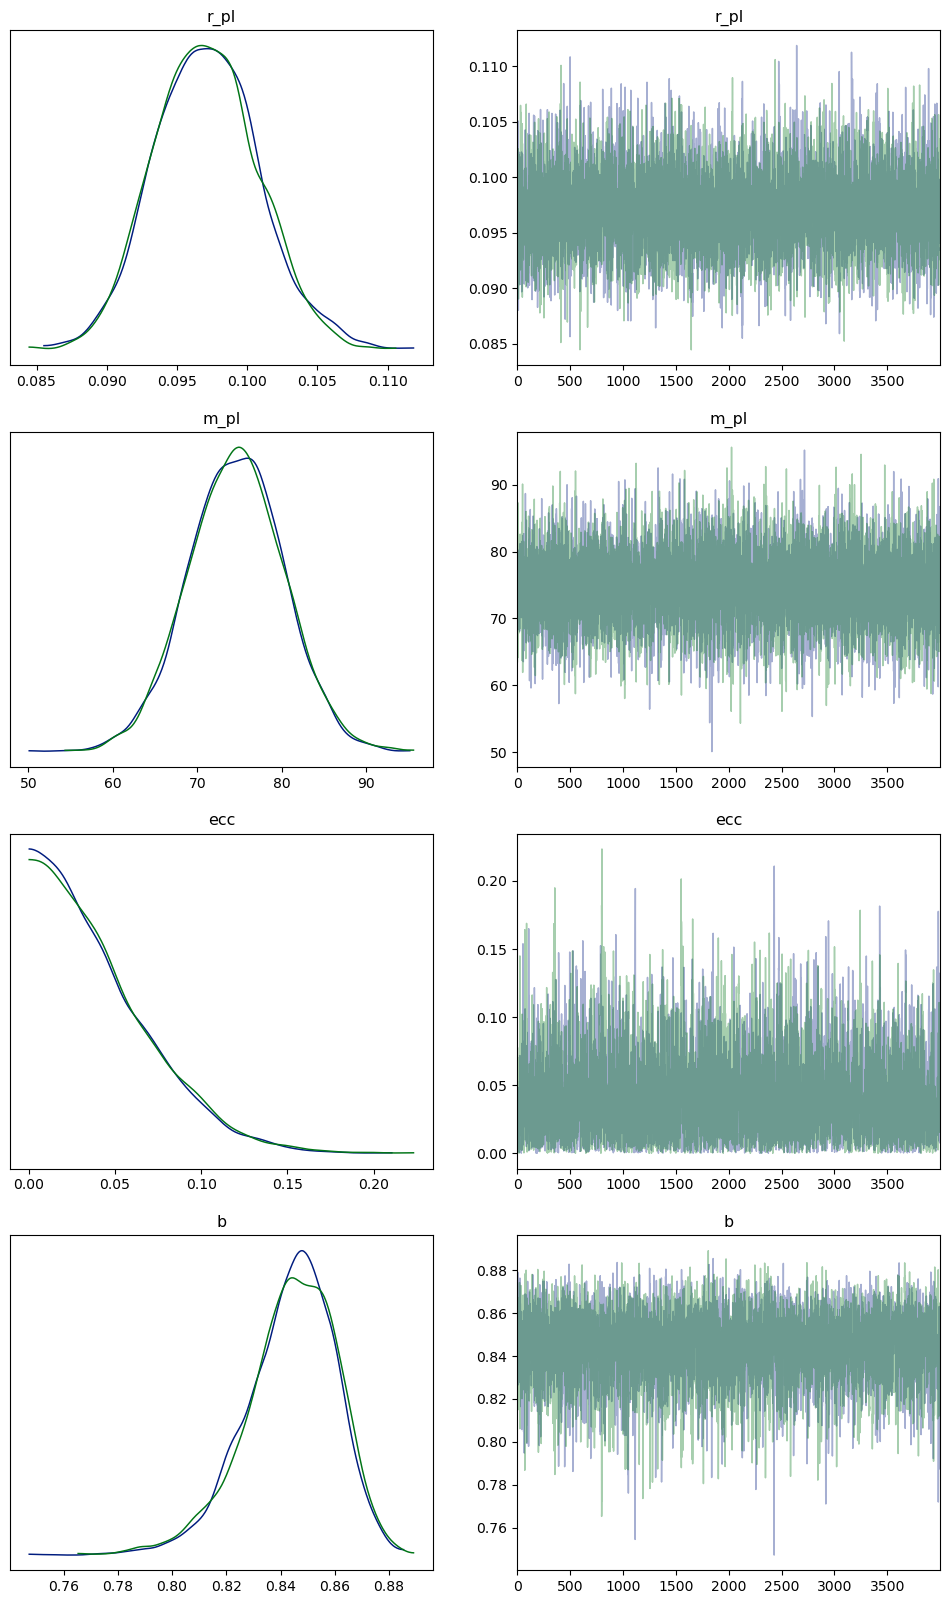

In [63]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

_ = az.plot_trace(trace, var_names=['r_pl', 'm_pl','ecc', 'b'] #log_depth or log_ror
                                    , compact=False, figsize=(12,20)) # SAMPLED 1 #ror instead of log_depth
# _ = az.plot_trace(trace, var_names=['log_period', 'log_m_pl', 't0', 'r_star', 'm_star']
#                                    , compact=False, figsize=(12,20)) # SAMPLED 2
# _ = az.plot_trace(trace, var_names=['ecs', 'b', 'u_star', 'mean']
#                                    , compact=False, figsize=(12,25)) # SAMPLED 3
# plt.savefig('trace_joint_1199_1.png',dpi=200,bbox_inches='tight')

In [64]:
trace3 = trace.copy()
trace3.posterior['r_pl'] = trace3.posterior['r_pl']*9.73116

In [65]:
CORNER_KWARGS = dict(
    smooth=0.9,
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

<Figure size 1400x1400 with 0 Axes>

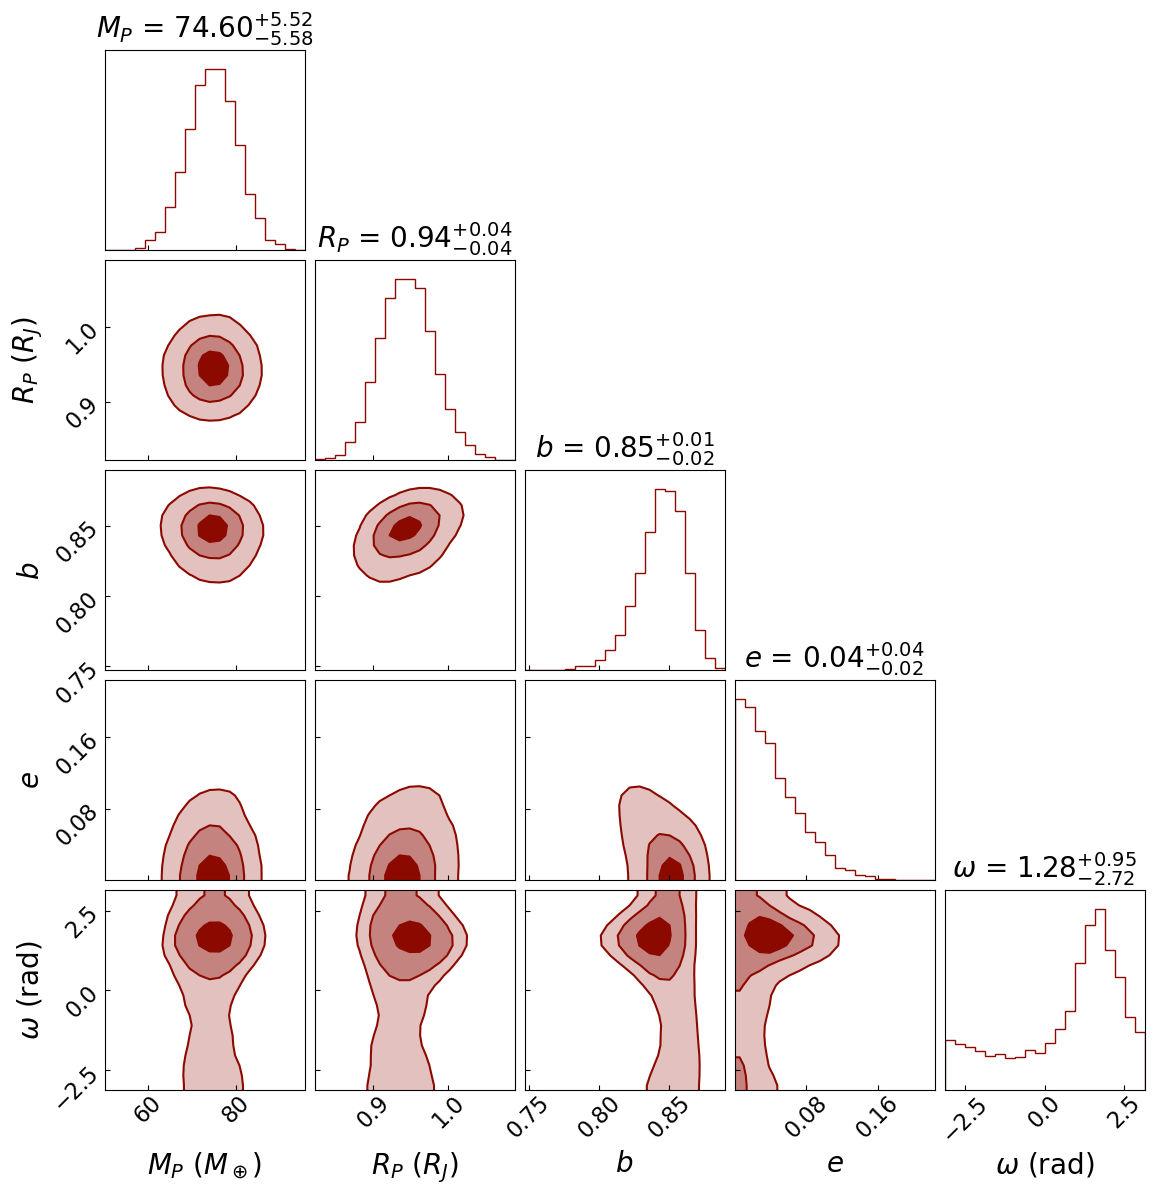

In [66]:
from cProfile import label
import corner
plt.figure(figsize=(14,14))
# figure = corner.corner(trace3, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
#                         labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
#                         show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
#                         labelpad=0, color='C2', quantiles=[0.16, 0.5, 0.84], **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
figure = corner.corner(trace3, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
                        labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
                        show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
                        labelpad=0, color='C2', **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
for ax in figure.get_axes():
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
#plt.savefig('corner_1199_paper.png',dpi=300,bbox_inches='tight', facecolor='w')
plt.show()

## LC Phase plot

In [67]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p_ = np.median(flat_samps["period"])
t0_ = np.median(flat_samps["t0"])
tess_mean = np.median(flat_samps["tess_mean"])
keplercam_B_mean = np.median(flat_samps["keplercam_B_mean"])
keplercam_z_mean = np.median(flat_samps["keplercam_z_mean"])
muscat_zs_mean = np.median(flat_samps["muscat_zs_mean"])
muscat_r_mean = np.median(flat_samps["muscat_r_mean"])
muscat_g_mean = np.median(flat_samps["muscat_g_mean"])
muscat_i_mean = np.median(flat_samps["muscat_i_mean"])

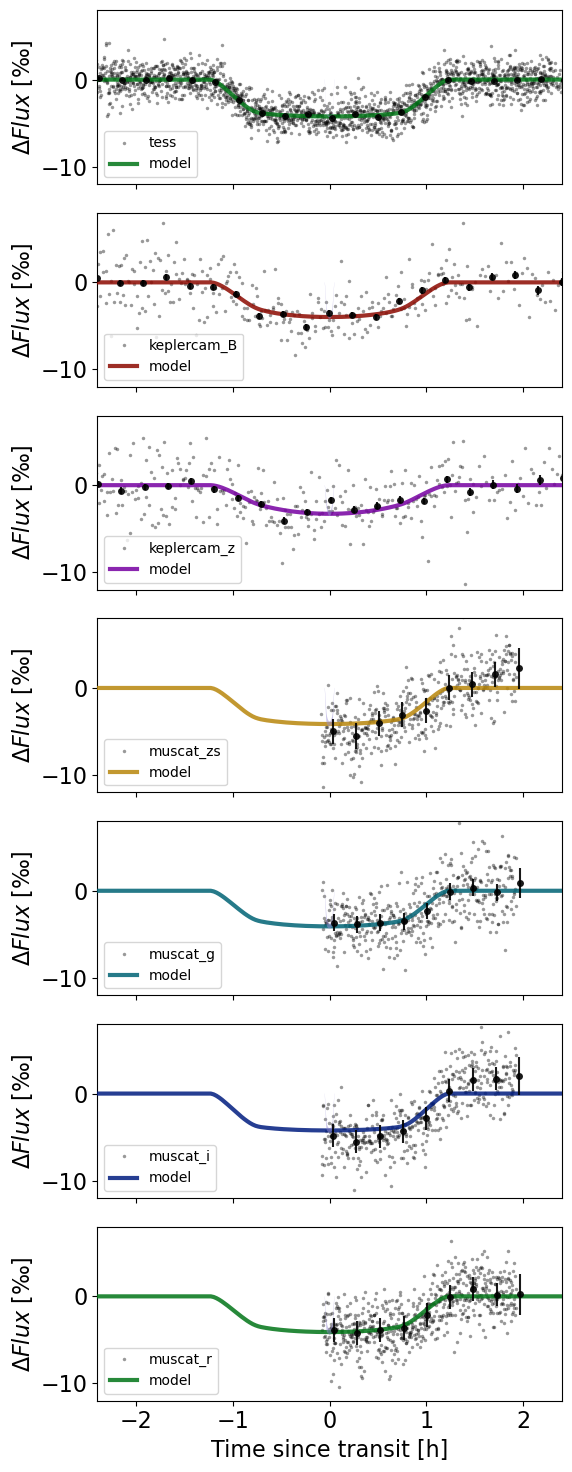

In [68]:
fig, axes = plt.subplots(7, sharex=True, sharey=True, figsize=(6, 15))

for n, name in enumerate(datasets):
    ax = axes[n]

    # plot the folded transits
    x, y, yerr = datasets[name][:3]
    folded = (x - t0_ + 0.5 * p_) % p_ - 0.5 * p_
    mean = np.median(flat_samps[f"{name}_mean"])
    ax.plot(folded*24, (y  - mean), ".k", alpha=0.4, label=f"{name}", mec="none", ms=5)
    # ax.annotate(
    #     name,
    #     xy=(1, 0),
    #     xycoords="axes fraction",
    #     va="bottom",
    #     ha="right",
    #     xytext=(-3, 3),
    #     textcoords="offset points",
    #     fontsize=14,
    # )
    # Overplot the phase binned light curve with rmse as error bars
    lcc = lk.LightCurve(time=folded, flux=y - mean, flux_err=yerr)
    lcc_binned = lcc.bin(time_bin_size=0.01)
    ax.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                 ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=900)
    # overplot the model
    pred = np.percentile(flat_samps[f"{name}_lc_pred"], [16, 50, 84], axis=-1)
    ax.plot(phase_lc*24, pred[1], color=f"C{n+1}", label="model", zorder=800, linewidth=3, alpha=0.85)
    art = ax.fill_between(phase_lc, pred[0], pred[2], color="#988ED5", alpha=0.5, zorder=800)
    art.set_edgecolor("none")
    ax.legend(fontsize=10, loc=3)

axes[-1].set_xlim(-0.10*24, 0.10*24)
axes[-1].set_xlabel("Time since transit [h]")
axes[-1].set_ylim(-12, 8)
for ax in axes:
    ax.set_ylabel(u'$\Delta Flux$ [‰]')

plt.tight_layout()

#plt.savefig('lcs_fits.png', dpi=200, bbox_inches='tight')

## RV Phase plot

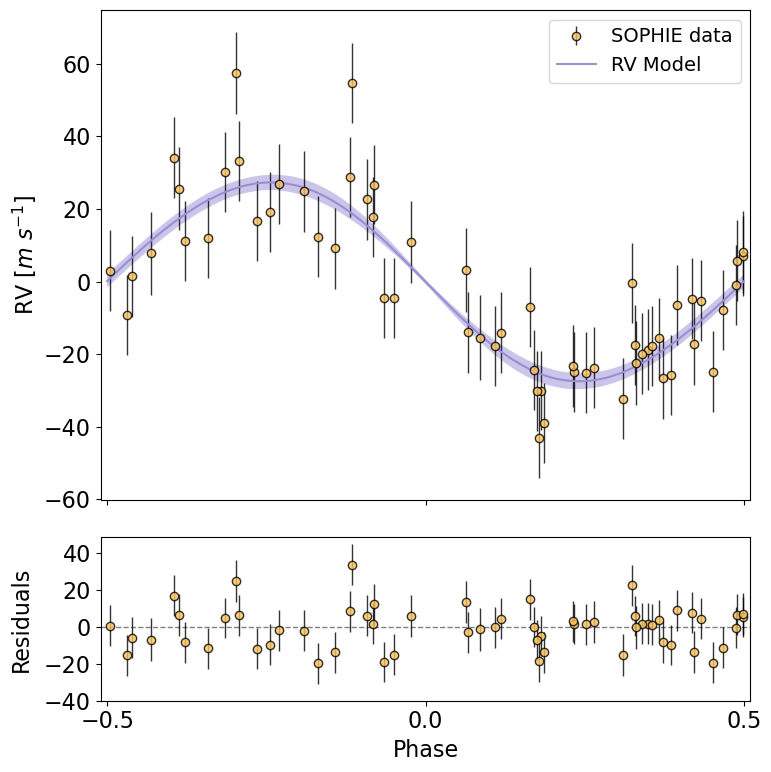

In [69]:
rv_jitter = np.exp(np.median(flat_samps['log_sigma_rv']))
bkg_ = np.median(flat_samps['bkg'].values, axis=-1)
rv_model_ = np.median(flat_samps['rv_model'].values, axis=-1)

# Plot the folded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3,1]})
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E', 
            markeredgecolor='k', ecolor='k', elinewidth=1, label='SOPHIE data', alpha=0.8)

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
ax1.plot(t_fold[inds]/p_, pred[1], color="#988ED5", label="RV Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="#988ED5", alpha=0.5)
art.set_edgecolor("none")

ax1.set_xlim(-0.51, 0.51)
ax1.set_ylabel("RV [$m~s^{-1}$]")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], fontsize=14, loc='best')

# Plot the folded residuals
ax2.axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
ax2.errorbar(x_fold/p_, y_rv-rv_model_-bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E',
            markeredgecolor='k', ecolor='k', elinewidth=1, alpha=0.8, label='residuals')
ax2.set_ylabel('Residuals', labelpad=8)
ax2.set_xlabel("Phase")
ax2.set_xlim(-0.51, 0.51)
ax2.set_xticks([-0.5, 0, 0.5])
ax2.set_yticks([-40,-20, 0, 20, 40])
plt.tight_layout()
#plt.savefig('fit_rv_joint_1199.png', dpi=300, bbox_inches='tight', facecolor='white')

### Periodograms with residues

In [86]:
ls_res = LombScargle(data.bjd, y_rv-rv_model_-bkg_)
frequency_res, power_res = ls_res.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)
faps_res = ls_res.false_alarm_level(probabilities)  

/tmp/ipykernel_28312/2120416319.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([0.2,0.4,0.6,0.8,1.0])


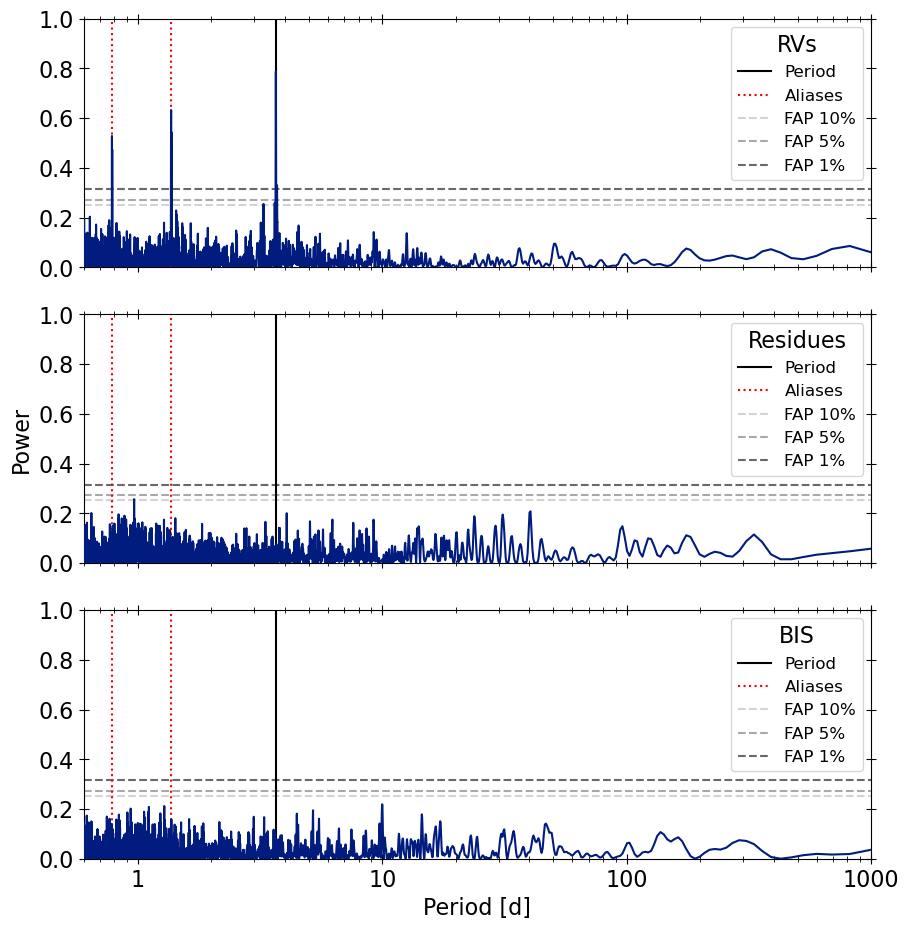

In [155]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 10), tight_layout=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
axes[0].plot(1/frequency, power, zorder=10) 
axes[1].plot(1/frequency_res, power_res, zorder=10)
axes[2].plot(1/frequency_bis, power_bis, zorder=10) 

# plot the 'bls_period' as a vertical line behind the plot and show in legend
axes[0].axvline(bls_period, ls='-', color='k', label='Period', zorder=-10)
axes[1].axvline(bls_period, ls='-', color='k', label='Period', zorder=-10)
axes[2].axvline(bls_period, ls='-', color='k', label='Period', zorder=-10)

# add the aliases as red dashed vertical lines
for i in range(3):
    axes[i].axvline(aliases[0], ls=':', color='red', label='Aliases')
    axes[i].axvline(aliases[2], ls=':', color='red')

# overplot the false alarm probabilities
names2 = [faps, faps_res, faps_bis]
for i, names in enumerate(names2):
    axes[i].axhline(names[0], ls='--', color='lightgray', label='FAP 10%', zorder=-20)
    axes[i].axhline(names[1], ls='--', color='darkgray', label='FAP 5%', zorder=-20)
    axes[i].axhline(names[2], ls='--', color='dimgray', label='FAP 1%', zorder=-20)

axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')

axes[0].set_xticklabels([0.2,0.4,0.6,0.8,1.0])
# set legends for all plots in the top right corner
axes[0].legend(loc='upper right', fontsize=12)
axes[1].legend(loc='upper right', fontsize=12)
axes[2].legend(loc='upper right', fontsize=12)
# add legend title
axes[0].legend(loc='upper right', fontsize=12, title='RVs')
axes[1].legend(loc='upper right', fontsize=12, title='Residues')
axes[2].legend(loc='upper right', fontsize=12, title='BIS')
axes[0].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[1].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[2].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[0].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')
axes[1].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')
axes[2].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)
axes[2].xaxis.set_major_formatter(formatter)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Period [d]")
plt.ylabel("Power")
# enlarge the xticks
plt.show()

## Density

In [70]:
from uncertainties import ufloat
from uncertainties.umath import *

rpl = ufloat((radio *u.R_jup).to(u.cm).value, (radio_err *u.R_jup).to(u.cm).value)  
mpl = ufloat((masa *u.M_jup).to(u.g).value, (masa_err *u.M_jup).to(u.g).value)

densidad = mpl * 1/(4 / 3 * np.pi * rpl**3)
print(densidad)

0.35+/-0.05


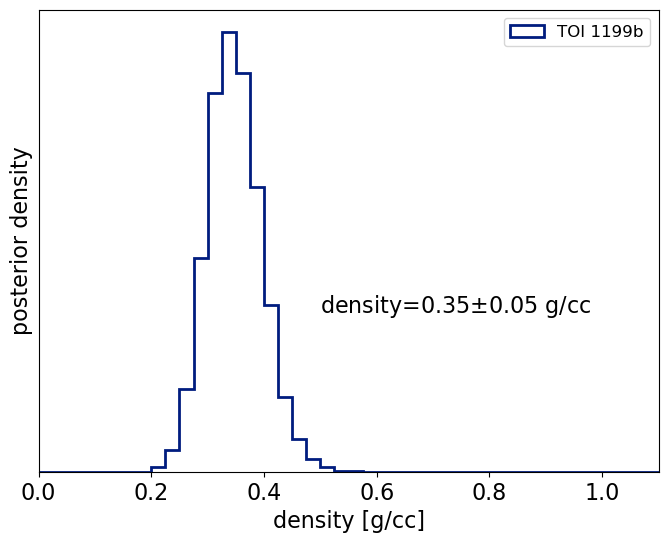

In [71]:
volume = 4 / 3 * np.pi * flat_samps["r_pl"].values ** 3
density = u.Quantity(flat_samps["m_pl"].values / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
plt.hist(
        density,
        bins,
        histtype="step",
        lw=2,
        label='TOI 1199b',
        density=True,)
plt.yticks([])
plt.legend(fontsize=12)
plt.text(0.5, 3, 'density={:.2f}$\pm${:.2f} g/cc'.format(np.median(density), np.std(density)))
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")
#plt.savefig('density_joint_1199.png',dpi=200,bbox_inches='tight')